In [1]:
import sys; sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

LOADING DATA FROM KAGGLE

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 90% 89.0M/98.7M [00:01<00:00, 65.8MB/s]
100% 98.7M/98.7M [00:01<00:00, 61.3MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/melanoma-skin-cancer-dataset-of-10000-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input

In [6]:
train_path = '/content/melanoma_cancer_dataset/train'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

Found 9605 files belonging to 2 classes.


In [7]:
test_path = '/content/melanoma_cancer_dataset/test'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 1000 files belonging to 2 classes.


DATASET SPLITTING

In [8]:
DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

240 61


DATASET VISUALIZATION

In [9]:
import matplotlib.pyplot as plt

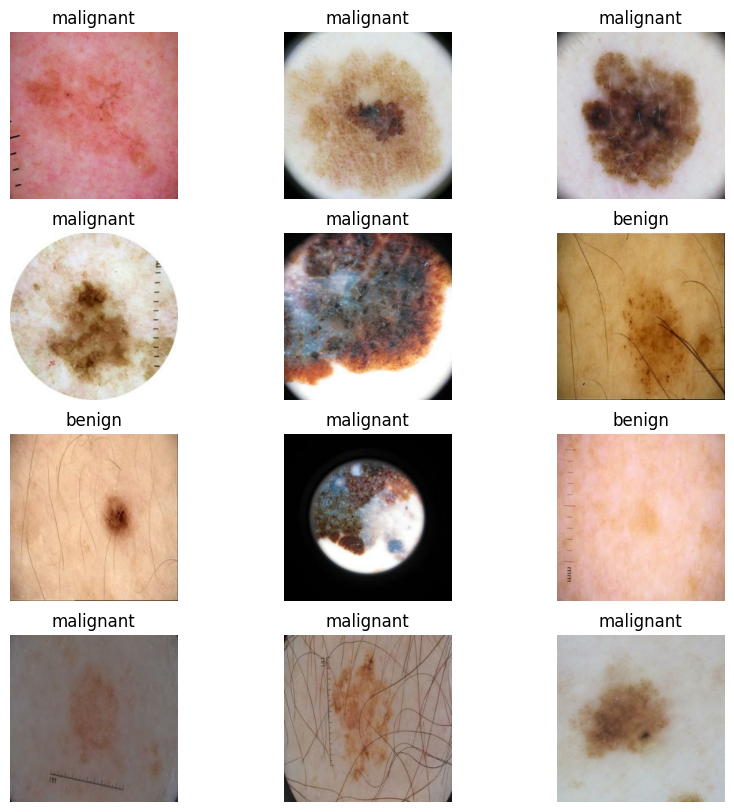

In [10]:
class_names = ds.class_names
plt.figure(figsize= (10,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis('off')

MODEL BUILDING

In [11]:
from keras.layers import RandomFlip, RandomRotation

In [12]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [13]:
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label
train, val, test = train.map(Normalizer), val.map(Normalizer), test.map(Normalizer)

In [14]:
!pip install keras

In [15]:
from tensorflow.keras.applications import ResNet50V2

In [16]:
ResNet = ResNet50V2(weights='imagenet', include_top=False, input_shape= (256,256,3))

model = Sequential ([
    Augmentation,
    Input((32, 256, 256, 3)),
    ResNet,
    MaxPooling2D(pool_size= (2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid'),
])

model.build(input_shape=(32, 256, 256, 3))

model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 4, 4, 2048)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (32, 32768)               0         
                                                                 
 dense (Dense)               (32, 64)                  

In [17]:
model.compile(
    optimizer= 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy',]
)

In [18]:
from keras.callbacks import EarlyStopping

In [19]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True,
)

MODEL TRAINING

In [20]:
history = model.fit(train, batch_size= 32, epochs=25, verbose=1, validation_data=val, callbacks=[early_stopping])

Epoch 1/25
240/240 [==============================] - 158s 461ms/step - loss: 0.4094 - accuracy: 0.8526 - val_loss: 1.0626 - val_accuracy: 0.8660
Epoch 2/25
240/240 [==============================] - 110s 455ms/step - loss: 0.4679 - accuracy: 0.8467 - val_loss: 806.7405 - val_accuracy: 0.4862
Epoch 3/25
240/240 [==============================] - 105s 438ms/step - loss: 0.4289 - accuracy: 0.8608 - val_loss: 0.2962 - val_accuracy: 0.8816
Epoch 4/25
240/240 [==============================] - 109s 455ms/step - loss: 0.3549 - accuracy: 0.8711 - val_loss: 2.1153 - val_accuracy: 0.7371
Epoch 5/25
240/240 [==============================] - 109s 455ms/step - loss: 0.3203 - accuracy: 0.8789 - val_loss: 1.1918 - val_accuracy: 0.6171
Epoch 6/25
240/240 [==============================] - 103s 430ms/step - loss: 0.2868 - accuracy: 0.8863 - val_loss: 0.2245 - val_accuracy: 0.9096
Epoch 7/25
240/240 [==============================] - 109s 454ms/step - loss: 0.2985 - accuracy: 0.8828 - val_loss: 0.3479

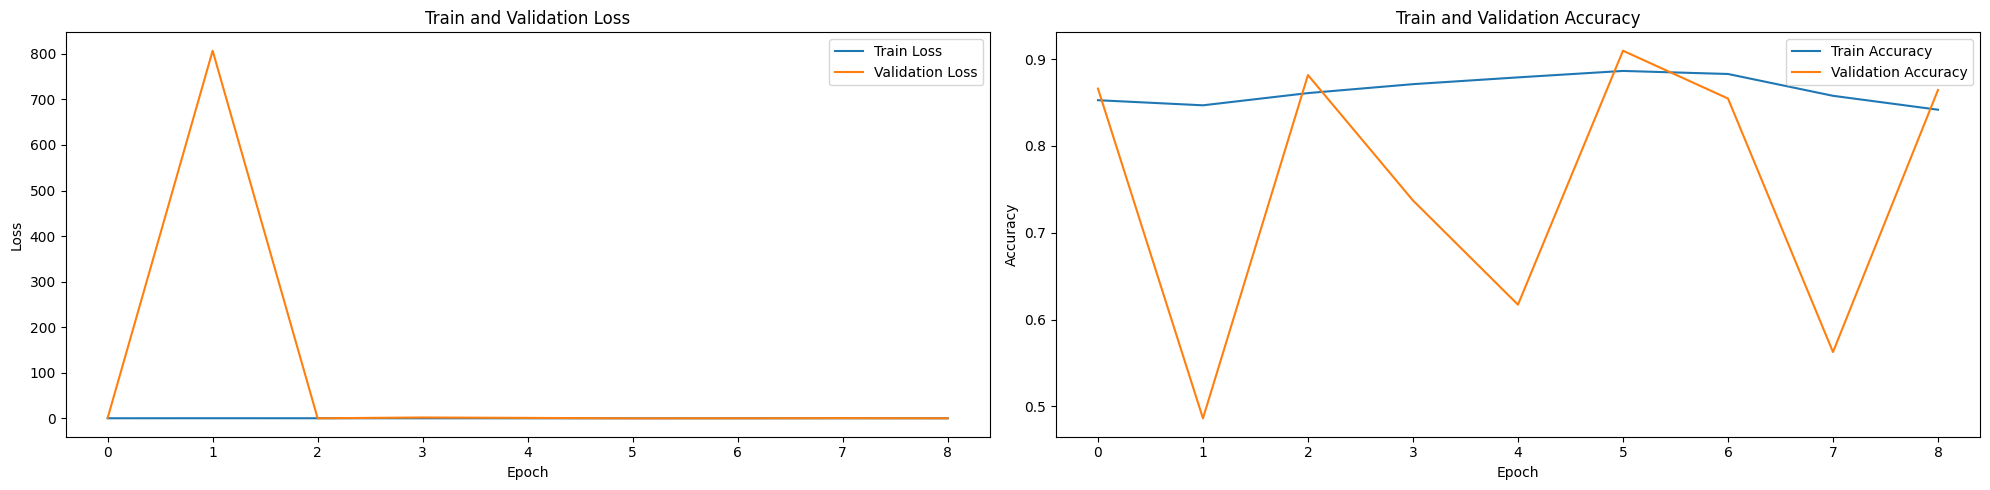

In [32]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.tight_layout()

MODEL EVALUATION

In [22]:
loss, accuracy = model.evaluate(test); print(loss, accuracy)

32/32 [==============================] - 6s 158ms/step - loss: 0.2535 - accuracy: 0.8920
0.25352442264556885 0.8920000195503235


Actual Label:  benign
1/1 [==============================] - 0s 44ms/step
Predicted Label:  benign


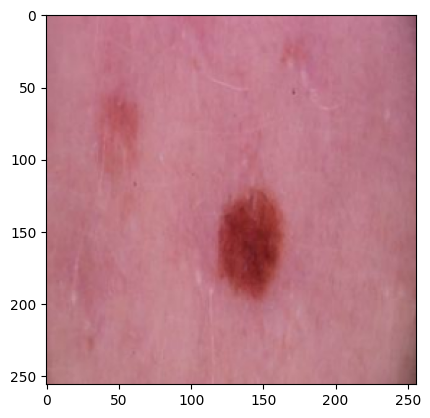

In [31]:
for images, label in test.take(1):
  img = (images[0]*255).numpy().astype('uint8')
  plt.imshow(img)
  print('Actual Label: ', class_names[label[0].numpy()])
  pred = model.predict(images)
  print('Predicted Label: ', class_names[np.argmax(pred[0])])

In [33]:
model.save('modelv3.h5')